<a href="https://colab.research.google.com/github/orbenishay/Classification/blob/master/Toxic_comments_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Toxic comments classification**
![](https://techcrunch.com/wp-content/uploads/2013/06/hatespeech-tilt.jpg?w=200&crop=1)

Pre-processing:
* convert to lowercase
* decide if to replace \n by space or period
* remove words that have numbers inside them
* remove any other non letter charachter
* RE:

Questions:
* We may want to use a trained model instead of training on this limied dataset.
* Which word embedding methodology to use? BOW (Bag Of Word),Word2Vec,Doc2Vec,  FastText,TFIDF
* Strategy\plan how to clean the vocabulary
* Derive direct feaures from the text
* Classification of 6 categories
* Apply word vectors on comments
* EDA: correlation between the columns
* Kaggle collaborate on notebook

Direct features:
* contains question Mark
* contains exclamation mark (especially multiple - and count them)
* contains words with all capital
* begins with hi (or similar)
* begins with 'I'; begins with 'You'
* begins with a capital or small letter
* contains parenthesis
* conains curses from a glosary: fuck, shit, ass, looser, dick, bitch, suck, Nazi,stupid, bullshit, piss, cock, jew, die, cunt, rape, gay, cut, looser, nigger
*  contains negative words: bad, terrible, kill, block, stop, wrong, destroy, absurd, don't, mom, mother, fat
* conains A$$HOLE, NIGGA, FVCK, cra*p, fxxk
* abbreviations: OMG, LMAO, WTF, FFS

Remove:
* Multiple spaces
* Usernames: JacobBarnett52698
* email addresses
* '=', '-',
* IP addresses
* DateTime
* Comments that are less than 4 charachters
* Names (words that start with capital at middle of sentence)

Terms:
* tockens
* corpus: a collection of documents/sentences
* NLP: Neuro-linguistic programming
* NLTK: Natural Language Toolkit
* tokenize = splitting a comment into the component words


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import re
import sys
import tensorflow as tf
from sklearn.manifold import TSNE # t-distributed Stochastic Neighbor Embedding; to visualize high-dimensional data. 
from sklearn.feature_extraction.text import TfidfVectorizer # Convert a collection of raw documents to a matrix of TF-IDF features.
import gensim
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec, KeyedVectors
from wordcloud import WordCloud, STOPWORDS
! pip install nltk
import nltk #natural language tool kit
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
!pip install replacer #replace with regex

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import files
    uploaded = files.upload()

Saving train10000.csv to train10000.csv


Get the data

In [3]:
traincomments=pd.read_csv('train10000.csv')
# traincomments.head()
traincomments.info()
# traincomments.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             10000 non-null  object
 1   comment_text   10000 non-null  object
 2   toxic          10000 non-null  int64 
 3   severe_toxic   10000 non-null  int64 
 4   obscene        10000 non-null  int64 
 5   threat         10000 non-null  int64 
 6   insult         10000 non-null  int64 
 7   identity_hate  10000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 625.1+ KB


Add columns

In [0]:
traincomments['number_categories']= traincomments.iloc[:, 2:8].sum(axis=1) # categories count
traincomments['any_category']= traincomments[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].max(axis=1)
traincomments['exclamation_mark_count']=traincomments['comment_text'].str.count('!') # count '!'
def find_exclamation_mark_consecutive(x):
    n = 0
    matches = re.findall(r'[!]{2,}', x) 
    for m in matches:
        if  len(m)>n:
            n=len(m)
    return n
traincomments['exclamation_mark_consecutive']=traincomments['comment_text'].apply(lambda x: find_exclamation_mark_consecutive(str(x)))
traincomments['question_mark_count']=traincomments['comment_text'].str.count('\?') # count '?'
def find_question_mark_consecutive(x): 
    n = 0
    matches = re.findall(r'[?]{2,}', x) 
    for m in matches:
        if  len(m)>n:
            n=len(m)
    return n 
traincomments['question_mark_consecutive']=traincomments['comment_text'].apply(lambda x:find_question_mark_consecutive(str(x))) 
traincomments['comment_characters']=traincomments['comment_text'].str.len() #count characters
traincomments['comment_words']=traincomments['comment_text'].str.split().str.len() # count words
traincomments['comment_short']=traincomments['comment_text'].apply(lambda x: len(str(x))<=100) # number of characters less than 100
#Sentense count in each comment:
    #use '\n' to count the number of sentences in each comment #?,!,.; (list)
# traincomments['count_sentences']=traincomments.comment_text.apply(lambda x: len(re.findall("\n",str(x)))+1)
traincomments['count_sentences']=traincomments.comment_text.apply(lambda x: len(nltk.tokenize.sent_tokenize(str(x))))
traincomments['count_unique_word']=traincomments.comment_text.apply(lambda x: len(set(str(x).split()))) # count unique words
#count upper case words:
traincomments["count_words_upper"] = traincomments.comment_text.apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#count title case words:
traincomments["count_words_title"] = traincomments.comment_text.apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords:
eng_stopwords = set(stopwords.words("english"))
traincomments["count_stopwords"] =traincomments.comment_text.apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words:
traincomments["mean_word_len"] = traincomments.comment_text.apply(lambda x: np.mean([len(w) for w in str(x).split()]))
#if there is any word with all upper:
# traincomments['all_upper']=traincomments['comment_text'].str.split().apply(lambda x: np.any([True if w.isupper() else False for w in x]))
#the comment begins with greeting:
traincomments['begins_greeting'] = traincomments['comment_text'].apply(lambda x: True if re.match('^hey|hi|hello', str(x), re.IGNORECASE) else False)
#if begine with "I":
traincomments['begins_I'] = traincomments['comment_text'].apply(lambda x: True if re.match('^I ', str(x), re.IGNORECASE) else False)
#if begins with "You":
traincomments['begins_You'] = traincomments['comment_text'].apply(lambda x: True if re.match('^You', str(x), re.IGNORECASE) else False)
#if begins with capital:
traincomments['begins_capital'] = traincomments['comment_text'].apply(lambda x: True if re.match('^[A-Z].*', str(x)) else False)
# if contains_parenthesis:
traincomments['contains_parenthesis'] = traincomments['comment_text'].apply(lambda x: True if re.search('\(|\)', str(x)) else False)
#if contains curse:
traincomments['contains_curse'] = traincomments['comment_text'].apply(lambda x: True if re.search('fuck|shit |ass| looser | dick|bitch|suck|Nazi|stupid|bullshit| piss | cock|jew| die | cunt| rape | gay | nigger | pussy|wank|faggot|dumb| crap | slut ', str(x),re.IGNORECASE) else False)
# if contains curse with replacement:
traincomments['contains_curse_replacement'] = traincomments['comment_text'].apply(lambda x: True if re.search('A$$HOLE|NIGGA|FVCK|cra*p|fxxk|b*tch', str(x),re.IGNORECASE) else False)
#contains negative terms:
traincomments['contains_negative_terms'] = traincomments['comment_text'].apply(lambda x: True if re.search(' bad | terrible | kill | block | stop | wrong | destroy | absurd | don\'t | mom | mother | fat | cut | burn | ugly | kick | liar ', str(x),re.IGNORECASE) else False)
#contains abbreviations:
traincomments['contains_abbreviations'] = traincomments['comment_text'].apply(lambda x: True if re.search(' OMG | LMAO |WTF|FFS', str(x),re.IGNORECASE) else False)

# **Data Exploration:**

In [5]:
# traincomments.shape
traincomments.nunique()
# traincomments.info()
# traincomments.describe()
# print(traincomments.obscene.value_counts())
# print(traincomments.threat.value_counts())
# print(traincomments.insult.value_counts())
# print(traincomments.identity_hate.value_counts())
# print(traincomments.toxic.value_counts())
# print(traincomments.severe_toxic.value_counts())

id                              10000
comment_text                     9980
toxic                               2
severe_toxic                        2
obscene                             2
threat                              2
insult                              2
identity_hate                       2
number_categories                   7
any_category                        2
exclamation_mark_count             41
exclamation_mark_consecutive       24
question_mark_count                23
question_mark_consecutive          13
comment_characters               1571
comment_words                     524
comment_short                       2
count_sentences                    66
count_unique_word                 348
count_words_upper                  80
count_words_title                 140
count_stopwords                   317
mean_word_len                    4034
begins_greeting                     2
begins_I                            2
begins_You                          2
begins_capit

The data does not contain missing values

# **Preliminary EDA**

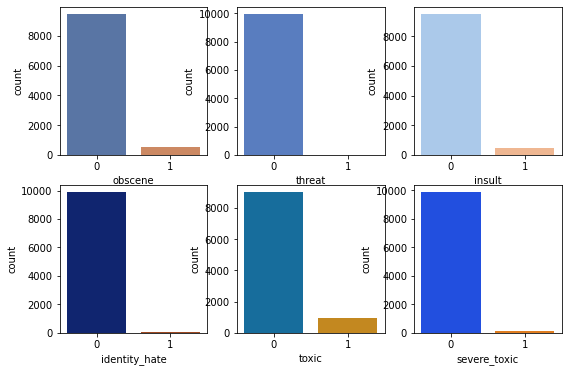

In [6]:
fig, plots = plt.subplots(2,3,figsize=(9,6))
plot1, plot2, plot3, plot4, plot5, plot6 = plots.flatten()
sns.countplot(traincomments['obscene'], palette= 'deep', ax = plot1)
sns.countplot(traincomments['threat'], palette= 'muted', ax = plot2)
sns.countplot(traincomments['insult'], palette = 'pastel', ax = plot3)
sns.countplot(traincomments['identity_hate'], palette = 'dark', ax = plot4)
sns.countplot(traincomments['toxic'], palette= 'colorblind', ax = plot5)
sns.countplot(traincomments['severe_toxic'], palette= 'bright', ax = plot6)

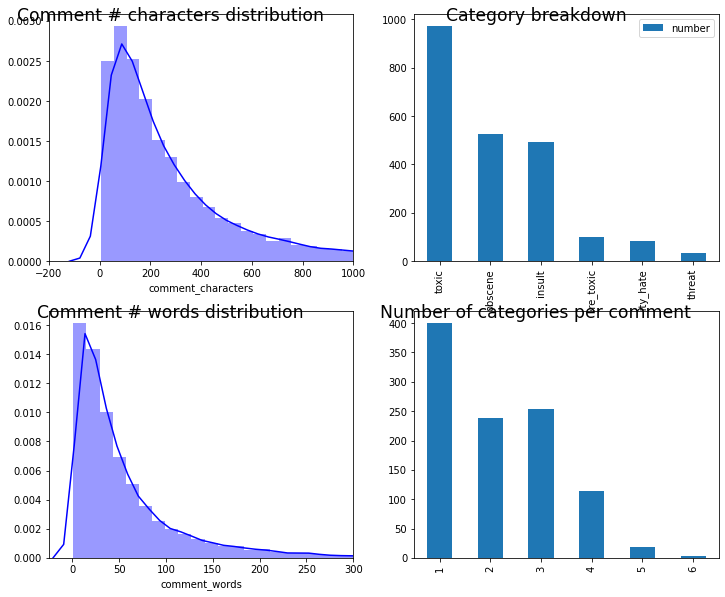

In [7]:
sums=traincomments[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum(axis=0)
sums_df=pd.DataFrame(data=sums, columns=['number'])
fig = plt.figure()
fig.set_size_inches(12,10)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.set_title("Comment # characters distribution", x=0.4, y=0.95, ha='center', fontsize='xx-large');
ax2.set_title("Category breakdown", x=0.4, y=0.95, ha='center', fontsize='xx-large');
ax3.set_title("Comment # words distribution", x=0.4, y=0.95, ha='center', fontsize='xx-large');
ax4.set_title("Number of categories per comment", x=0.4, y=0.95, ha='center', fontsize='xx-large');
sns.distplot(traincomments.comment_characters, bins=100, kde=True, color='blue', ax=ax1);
ax1.set_xlim(-200,1000)
sums_df.sort_values(by='number',ascending=False).plot.bar(ax=ax2);
sns.distplot(traincomments.comment_words, bins=100, kde=True, color='blue', ax=ax3);
ax3.set_xlim(-25,300)
traincomments[traincomments['number_categories']>0]['number_categories'].value_counts().sort_index(ascending=True).plot.bar(ax=ax4);
plt.show()


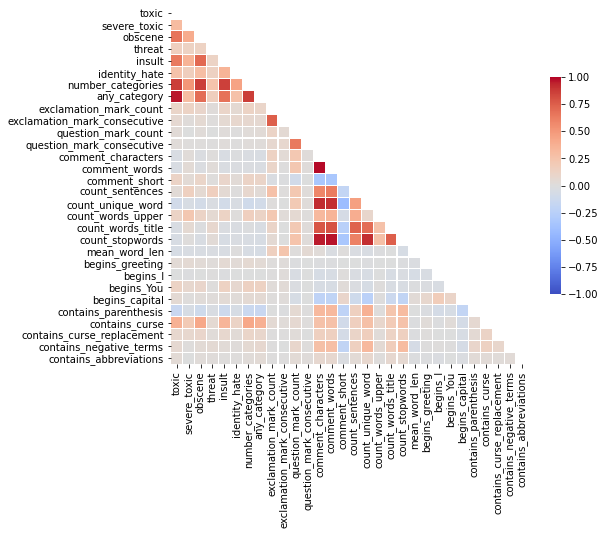

In [8]:
# corr_df = traincomments[traincomments['number_categories']>0]
corr_df = traincomments
corr=corr_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8,8))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=False, mask=mask, vmin=-1,vmax=1, center=0,
            square=True, linewidths=.1, cbar_kws={"shrink": .5}, annot_kws={"size": 7},cmap='coolwarm'); #

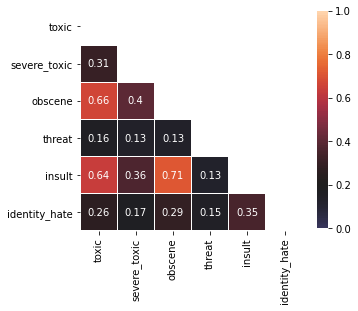

In [9]:
corr_df =traincomments[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
corr=corr_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(5,5))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, mask=mask, vmax=1,vmin=0, center=0.2,
            square=True, linewidths=.2, cbar_kws={"shrink": .8}, annot_kws={"size": 10});

In [0]:
traincomments.groupby('contains_curse').agg({'number_categories':'mean'}).head()

sums=traincomments[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum(axis=0)
sums_df=pd.DataFrame(data=sums, columns=['number'])

# comment_short                     2
# begins_greeting                   2
# begins_I                          2
# begins_You                        2
# begins_capital                    2
# contains_parenthesis              2
# contains_curse                    2
# contains_curse_replacement        2
# contains_negative_terms           2
# contains_abbreviations            2

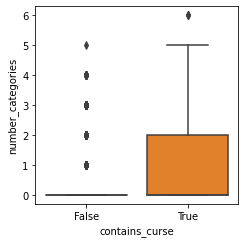

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
# ax2 = fig.add_subplot(222)
fig.set_size_inches(8,8)
sns.boxplot(x='contains_curse', y='number_categories', hue=None, data=traincomments, order=None, hue_order=None, ax=ax1);


# sns.violinplot(x='bathrooms', y='price', data=bnb,ax=ax2);
# ax1.set_title("Price distribution by bedrooms - BoxPlot", x=0.4, y=0.95, ha='center', fontsize='xx-large');
# ax2.set_title("Price distribution by bedrooms - Violin Plot", x=0.4, y=0.95, ha='center', fontsize='xx-large');

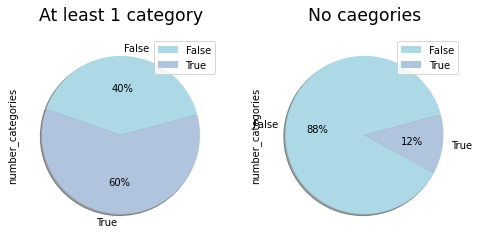

In [12]:
my_colors = ['lightblue','lightsteelblue','silver','lightseagreen','khaki','peachpuff']
fig = plt.figure()
fig.set_size_inches(8,8)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
traincomments[traincomments['any_category']==1].groupby('contains_curse').agg({'number_categories':'count'}).plot.pie(y='number_categories',autopct='%1.f%%', startangle=15,colors=my_colors,shadow = True, ax=ax1)
traincomments[traincomments['any_category']==0].groupby('contains_curse').agg({'number_categories':'count'}).plot.pie(y='number_categories',autopct='%1.f%%', startangle=15,colors=my_colors,shadow = True, ax=ax2)
ax1.set_title('At least 1 category', x=0.5, y=1.05, ha='center', fontsize='xx-large');
ax2.set_title('No caegories', x=0.5, y=1.05, ha='center', fontsize='xx-large');


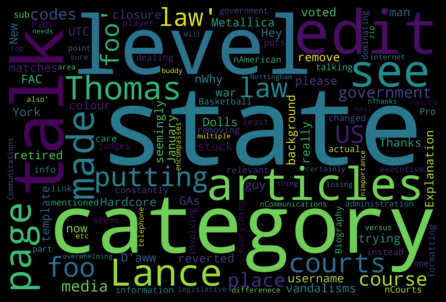

In [13]:
text = traincomments['comment_text'].values

wordcloud = WordCloud(width = 3000,height = 2000,background_color = 'black',stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(figsize = (6, 6), facecolor = 'k',edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# **Initial Cleanning & Tokenizing**

In [0]:
words_with_numbers_pattern = re.compile(r'\w*[\d]+\w*') # letter\s (0 or more), digit (1 or more), letter\s (0 or more)
special_chars_pattern = re.compile(r'[,."!?:;=&*\\/()\'$^#]+')
def clean(s):
    s = re.sub(words_with_numbers_pattern, '', s).strip()  # get rid of numbers or words with numbers 
    s = re.sub(special_chars_pattern, '', s)  # remove special chars without removing words
    # ''.join([char.strip(',."!?:;=&*\\/()\'$^#') for char in s])  # remove these characters - this is so slow-- change to re
    return s

In [0]:
comment_list = traincomments['comment_text'].values # gives a list of all comments (each is a string)
comment_list_lower=list(map(lambda x:x.lower(),comment_list))
# sentences_list = [re.split('[.\n!?]',line) for line in comment_list_lower] # gives a list of list (each list is a list of sentences corresponding to 1 comment)
comment_list_lower_splitline = [re.split('[\n]',line) for line in comment_list_lower] # gives a list of list (each list is a list of sentences corresponding to 1 comment)
splitline_flatten = [s for sentence in comment_list_lower_splitline for s in sentence] # gives a list of all sentences (i.e. the comments that we split only by \n)
sentences_list = list(map(lambda x:nltk.sent_tokenize(x),splitline_flatten))
sentences_flat = [s for sentence in sentences_list for s in sentence] # gives a list of all sentences; we loose the comment context
sentences_clean = [clean(s) for s in sentences_flat if len(s) > 1]
words_within_sentences = [s.split() for s in sentences_clean] # list of list; words within sentences
sentences = [words_list for words_list in words_within_sentences if len(words_list)>1] # remove lists with 1 word or less

## **Word2Vec**

In [0]:
model = Word2Vec(sentences, size=100, window=5, min_count=3, workers=4) # train the model
len(model.wv.vocab) #how many words in the vocabulary

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


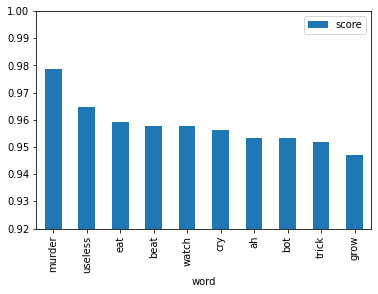

In [17]:
sims=model.wv.most_similar('kill')
sims_df=pd.DataFrame(data=sims, columns=['word','score'])
sims_df.sort_values(by='score',ascending=False).plot.bar('word','score',ylim=(0.92,1));
# def get_related_terms(token, topn=10):
#     for word, similarity in model.most_similar(positive=[token], topn=topn):
#         print (word, round(similarity, 3))

In [22]:
ordered_vocab = [(term, voc.index, voc.count) for term, voc in model.wv.vocab.items()] # build a list of the terms and count
ordered_vocab_sorted = sorted(ordered_vocab, key=lambda k: -k[2]) # sort by the term counts, most common appear first
ordered_terms, term_indices, term_counts = zip(*ordered_vocab_sorted) # unzip the terms, integer indices, and counts into separate lists
word_vectors = pd.DataFrame(model.wv.syn0norm[term_indices, :], index=ordered_terms) # create a DF: vectors (data); terms (index)
word_vectors.head(6)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
the,0.076485,0.025281,0.075577,0.046722,-0.152919,-0.092278,0.014021,0.000516,-0.158342,0.115087,0.035001,-0.058694,-0.033863,0.005127,0.068289,0.131332,0.144066,-0.065137,0.183557,-0.028518,-0.146741,0.073899,0.019448,-0.088674,-0.117654,-0.014377,0.052048,-0.001559,-0.137853,0.016607,-0.203037,-0.038283,-0.088126,-0.209170,-0.039716,0.194767,-0.058148,-0.018970,-0.136219,-0.024990,...,-0.003396,-0.067139,-0.012054,-0.041014,0.085671,0.057477,-0.124680,0.065056,0.118358,0.106119,0.131907,0.069456,0.105977,0.032379,0.057090,-0.196131,-0.045893,0.119337,0.079493,0.115184,-0.012814,0.064034,0.018765,0.140463,-0.069140,0.011826,-0.038290,-0.092241,-0.164589,-0.097377,0.071967,0.063235,-0.030820,0.140098,-0.085284,0.150295,-0.019863,0.140907,-0.125588,0.006566
to,-0.013380,-0.011902,0.024128,0.111482,0.081728,0.147833,0.205022,-0.135419,-0.010202,-0.101502,-0.042543,0.011912,0.026747,-0.135305,0.025475,0.037971,-0.021706,0.114930,0.150985,-0.084220,0.171571,0.179666,-0.130252,-0.043511,0.087539,-0.067905,0.166442,-0.104204,-0.159850,0.074082,0.149831,0.097464,0.072683,-0.114132,-0.114460,-0.025007,0.009355,0.226647,-0.044752,-0.003187,...,-0.056883,0.163368,0.106066,-0.023233,-0.027097,0.021509,-0.168968,0.022966,0.202436,0.166054,-0.069395,-0.006019,0.109372,-0.073657,0.094222,0.012585,-0.081330,-0.009183,-0.058299,0.147523,-0.105455,0.142805,0.122521,-0.055298,-0.073098,0.105627,-0.007036,-0.157887,-0.062050,-0.183727,0.048757,0.102797,-0.013769,0.062584,0.099121,0.093798,0.018264,-0.070109,0.058596,0.041761
of,0.150131,0.168490,0.074254,0.008775,-0.105297,-0.177415,-0.003792,-0.068784,0.025176,-0.033725,0.027737,0.142186,-0.099892,0.082839,0.050116,0.029339,0.253280,0.000450,0.124044,-0.078988,-0.061136,-0.038628,-0.018141,-0.051779,-0.011776,-0.066207,-0.124036,-0.034773,0.059027,0.125093,0.076237,0.018326,-0.133563,-0.220749,-0.006321,0.060178,0.013031,-0.096527,-0.089501,-0.015999,...,0.017720,0.030999,0.050941,-0.116482,-0.053698,0.135323,0.012168,0.146192,0.039860,0.028598,0.059350,-0.187876,0.024319,0.073502,0.166102,-0.017755,-0.037612,0.091577,0.044844,0.190808,-0.104463,0.064054,-0.092120,0.084501,-0.147851,-0.066295,0.099876,0.075386,-0.057861,-0.057042,-0.059112,-0.036170,0.099426,0.022970,-0.034307,0.033681,-0.007000,-0.067963,0.006824,-0.192828
and,0.089311,0.046252,-0.154483,0.063047,0.002848,0.117468,0.202044,-0.127515,0.121460,-0.018871,0.113380,0.011574,-0.007403,0.048959,-0.062349,-0.087571,0.201984,0.040526,0.160768,-0.160289,0.104667,0.049407,0.001447,-0.006283,0.004570,-0.121233,0.031795,-0.048656,-0.048980,0.015749,0.262499,-0.046915,0.029468,-0.163682,-0.017751,-0.028373,0.036871,-0.001215,-0.133664,0.151326,...,0.047136,0.024043,0.008649,-0.012488,-0.012492,0.154026,0.027346,-0.045972,0.127728,0.103345,0.083279,-0.052765,0.133786,-0.083994,0.027562,-0.004540,-0.188875,0.138276,-0.001288,0.131988,-0.209320,-0.000392,0.204927,0.026909,-0.088305,0.158480,0.068935,-0.081592,-0.031729,-0.055216,-0.052620,0.035329,-0.022988,0.004817,0.055642,0.095720,-0.014888,-0.056471,0.076294,-0.028382
you,0.039415,-0.035653,0.073222,-0.037512,-0.029513,0.100746,0.232407,-0.075977,0.028207,0.037077,0.027468,-0.016531,0.094502,-0.041374,0.014743,0.076269,-0.148912,0.313755,0.028808,-0.126795,0.018391,0.044234,-0.007439,0.090052,0.123702,-0.208571,0.014093,0.064604,-0.028834,-0.004316,0.128797,-0.076444,0.035569,-0.138302,0.039260,-0.033563,-0.019455,0.100012,-0.055468,-0.083577,...,-0.075251,0.114007,0.037771,-0.085697,-0.040308,0.092437,0.040843,0.123689,0.092034,0.115127,0.004880,0.051915,0.111471,0.003412,-0.088711,-0.102211,-0.091817,-0.016193,0.061190,-0.022906,0.070900,-0.072217,0.228824,-0.197241,0.084299,0.119639,0.080553,-0.103178,-0.038910,-0.108134,0.078340,0.228824,0.121560,0.078910

## **TNSE**
t-distributed stochastic neighbor embedding

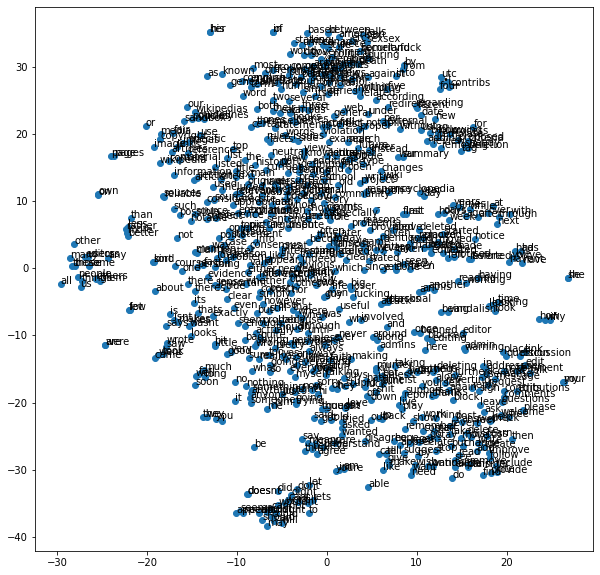

In [24]:

X = word_vectors[:700].to_numpy() # will use top most frequent
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, index=word_vectors[:700].index.tolist(), columns=['x', 'y'])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos)

### **add vector per comment to training df**
need to clean comment_list before this

In [25]:
wvc=word_vectors.columns.tolist()
cols=traincomments.columns.tolist()
cols.extend(wvc)
traincomments=traincomments.reindex(columns=cols)
for i, comment in enumerate(comment_list):
    org_words = clean(comment).split()
    words = [w for w in org_words if w in word_vectors.index]  #remove words not in model
    comment_vector=word_vectors.loc[words].mean(axis=0)   # average the word vectors for the comment (cum then normalize for word nmber)
    traincomments.loc[i, wvc]=comment_vector  # add the features to the df
traincomments.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,number_categories,any_category,exclamation_mark_count,exclamation_mark_consecutive,question_mark_count,question_mark_consecutive,comment_characters,comment_words,comment_short,count_sentences,count_unique_word,count_words_upper,count_words_title,count_stopwords,mean_word_len,begins_greeting,begins_I,begins_You,begins_capital,contains_parenthesis,contains_curse,contains_curse_replacement,contains_negative_terms,contains_abbreviations,0,1,2,3,4,5,6,7,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,0,0,0,1,0,264,43,False,3,41,2,11,18,5.162791,False,False,False,True,False,False,False,True,False,0.074780,0.018326,0.020870,0.009412,-0.015830,0.073681,0.093100,-0.087122,...,0.004871,-0.007257,-0.016382,-0.017871,0.049637,0.146035,-0.034411,0.042025,0.047061,0.108271,-0.030547,0.010942,0.071050,-0.006625,0.065518,-0.072261,-0.094146,0.051846,0.043342,0.106251,-0.052879,-0.002155,0.075883,0.000451,-0.056167,0.060711,0.007008,-0.033112,-0.068724,-0.117582,-0.015751,0.085106,0.031464,0.102889,-0.095984,0.142046,-0.019815,0.074862,0.018636,-0.002658
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,0,1,0,0,0,112,17,False,4,17,1,3,2,5.588235,False,False,False,True,True,False,True,False,False,0.128855,0.044300,-0.032672,0.032425,0.007842,0.065132,0.136715,-0.097499,...,0.006127,-0.039865,0.016396,-0.060481,0.078920,0.181456,0.014416,0.055681,0.102394,0.131833,0.027604,-0.050613,0.090095,-0.023453,0.099665,-0.069354,-0.074791,0.043587,-0.010602,0.116205,-0.068281,-0.007593,0.067927,0.026389,-0.070280,0.092322,0.027457,-0.054179,-0.034314,-0.157758,0.013618,0.100731,0.047735,0.080821,-0.107400,0.167164,-0.047309,0.081262,0.066108,0.040451
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,0,0,0,0,0,233,42,False,3,39,0,2,20,4.571429,True,False,False,True,False,False,False,False,False,0.096595,0.013710,0.020485,0.048676,0.012860,0.055904,0.139371,-0.033935,...,-0.005060,-0.030583,0.017779,-0.068918,0.068250,0.143329,-0.029901,0.047069,0.093440,0.132225,-0.014078,-0.019168,0.082062,-0.060695,0.045306,-0.060309,-0.077988,0.012872,-0.034214,0.133836,-0.040450,0.003349,0.057358,0.007927,-0.053609,0.073641,0.012469,-0.079890,-0.062580,-0.144506,0.031942,0.102917,0.041641,0.075455,-0.052653,0.128619,-0.012224,0.107071,0.044291,0.014451
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,0,0,0,0,0,622,113,False,4,82,5,7,56,4.486726,False,False,False,False,False,False,False,False,False,0.063702,0.027497,-0.007589,0.028833,-0.005755,0.066669,0.112565,-0.055693,...,-0.000098,-0.003290,-0.006309,-0.071709,0.048729,0.149565,-0.009974,0.067811,0.071225,0.120941,0.016676,-0.023509,0.094282,-0.035522,0.060831,-0.061621,-0.090190,0.018868,-0.024002,0.117824,-0.029506,0.014497,0.061915,0.022577,-0.048038,0.071028,0.036095,-0.058420,-0.049612,-0.129073,0.026549,0.081064,0.022025,0.073774,-0.053539,0.095464,-0.033421,0.076796,0.043313,0.021719
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,0,0,0,1,0,67,13,True,2,13,0,2,5,4.230769,False,False,True,True,False,False,False,False,False,0.098603,0.012246,0.029048,0.041323,0.034707,0.071500,0.159222,-0.056015,...,-0.009819,-0.030371,-0.006657,-0.040796,0.055485,0.152408,0.024417,0.038130,0.043596,0.090872,-0.024388,0.004920,0.072282,-0.051748,0.027253,-0.041245,-0.078508,-0.002341,-0.019798,0.090216,0.008069,-0.031968,0.068838,-0.024323,-0.034355,0.090108,0.028634,-0.065354,-0.046621,-0.131172,0.011208,0.108434,0.054247,0.088144,-0.057038,0.132927,-0.014408,0.128587,0.045913,0.006303


# **TF IDF**
“Term Frequency – Inverse Document Frequency

* **Term Frequency** : This summarizes how often a given word appears within a document.
* **Inverse Document Frequency**: This downscales words that appear a lot across documents. A term has a high IDF score if it appears in a few documents. Conversely, if the term is very common among documents (i.e., “the”, “a”, “is”), the term would have a low IDF score.

TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents. The higher the TFIDF score, the rarer the term is. For instance, in a Mortgage complaint the word mortgage would be mentioned fairly often. However, if we look at other complaints, mortgage probably would not show up in many of them. We can infer that mortgage is most probably an important word in Mortgage complaints as compared to the other products. Therefore, mortgage would have a high TF-IDF score for Mortgage complaints.

process: 
1. stopword cleanning
2. stemming (go, goes, going = go)/lemmatizing (he,she,it= do)
3. clean "junk"
4. vectorizer (take the corpus and convert each doc/sentence into a sparse matrix of TFIDF)
5. LSA (dimentionality reduction)

###**Cleanning** **preprocessing**

In [0]:
#cleanning:

replacement_patterns = [
 (r'won\'t', 'will not'),
 (r'can\'t', 'cannot'),
 (r'i\'m', 'i am'),
 (r'ain\'t', 'is not'),
 (r'(\w+)\'ll', '\g<1> will'),
 (r'(\w+)n\'t', '\g<1> not'),
 (r'(\w+)\'ve', '\g<1> have'),
 (r'(\w+)\'s', '\g<1> is'),
 (r'(\w+)\'re', '\g<1> are'),
 (r'(\w+)\'d', '\g<1> would'),
]

def strip_symbols(text):
    return ' '.join(re.compile(r'\W+', re.UNICODE).split(text))

class RegexpReplacer(object):
   def __init__(self, patterns=replacement_patterns):
      self.patterns = [(re.compile(regex), repl) for (regex, repl) in patterns]

   def replace(self, text):
      s = text
      for (pattern, repl) in self.patterns:
           s = re.sub(pattern, repl, s)
      return s

#stemmig:
from nltk.stem import WordNetLemmatizer
lemma = []
wnl = WordNetLemmatizer()
for sen in traincomments['comment_text']:
    tokens = [wnl.lemmatize(w) for w in sen]
    lemma.append(tokens)

# Removing Stopwords
filter_words = []
Stopwords = set(stopwords.words('english'))

#ab = spell('nd')
for sent in lemma:
    tokens = [w for w in sent if w not in Stopwords]
    filter_words.append(tokens)

space = ' ' 
for sentence in filter_words:
    sentences.append(space.join(sentence))


replacer=RegexpReplacer()
traincomments.comment_text = traincomments.comment_text.apply(lambda x:replacer.replace(x))
traincomments.comment_text = traincomments.comment_text.apply(lambda x:strip_symbols(x))

In [0]:
# TFIDF
tfidf_vectorizer=TfidfVectorizer(use_idf=True, stop_words = 'english')
 
# fit_transform
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(traincomments['comment_text'])

# get the first vector out (for the first document)
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0]

# place tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

In [0]:
names = tfidf_vectorizer.get_feature_names()
print(names)
print(len(names))

In [0]:
tfidf_vectorizer.vocabulary_

In [0]:
#LSA

#import the essential tools for lsa
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
#other imports
from os import listdir

# Fit LSA. Use algorithm = “randomized” for large datasets
lsa = TruncatedSVD(2, algorithm = 'arpack')
lsa = lsa.fit_transform(traincomments['comment_text'])
lsa = Normalizer(copy=False).fit_transform(traincomments['comment_text'])

pd.DataFrame(lsa.components_,index = ["component_1","component_2"],columns =
vectorizer.get_feature_names())